# Overview

In [1]:
#File Name: Figure_4.ipynb
#Author: Matthias M. Fischer
#Last Revision: 16th March 2022
#Changelog: Initial Version.

#This file contains the complete commented source code
#for reproducing all plots from Figure 4 of the manuscript
#by Fischer and Blüthgen.

# Setup

In [1]:
# Library imports

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tqdm

In [2]:
# Convenience function:
# Return the maximum real part of all
# eigenvalues of a given matrix M

def lambdamax(M):
    return np.max(np.real(np.linalg.eigvals(M)))

In [3]:
# Return the coefficient matrix A describing
# the model where all NSCC compartments
# dedifferentiate

def A(K_C=1.0,                                        # CSC cycling rate
      K_N=1.0,                                        # NSCC cycling rate
      K_T=0.05,                                       # Dedifferentiation rate
      DeltaP = 0.18,                                  # Aggregate CSC fate choice parameter, Delta P := P_S - P_D
      D_C=0.05,                                       # CSC apoptosis rate
      D_N=0.05,                                       # NSCC apoptosis rate
      M=7):                                           # Number NSCC compartments
    
    beta = DeltaP*K_C - D_C                           # CSC compartment net growth rate
    iota = (1-DeltaP)*K_C                             # Influx rate compartment N_1, in multiples of C(t)
 
    A = np.zeros((M+1, M+1))                          # Initialise coefficient matrix A
    A[0,0] = beta                                     # A_{1,1} := beta
    A[1,0] = iota                                     # A_{2,1} := iota
    
    for i in range(1, M+1):                           # A_{1,i} := K_T for i in [2...M]
        A[0,i] = K_T
    
    for i in range(1, M):                             # A_{i,i} := -K_N - K_T - D_N for i in [1,M-1]
        A[i,i] = -K_N - K_T - D_N
    
    A[M,M] = -K_T - D_N                               # A_{M+1, M+1} := -K_T - D_N
    
    for i in range(2,M+1):                            # A_{i, i-1} := 2*K_N for i in [2, M]
        A[i,i-1] = 2*K_N
        
    return A

In [4]:
# For a given system parametrisation, calculate
# the relative parameter sensitivities d_X^{rel}

def calculate_sensitivity_vector(params, h = 1e-6):
    sensitivities = []                                                   # Sensitivity vector to be returned   
    
    M_baseline = params[-1]                                              # Split parameter vector into M and rest,
    params_baseline = np.array(params[:-1])                              # as we do not perturb int M
  
    for i in range(len(params_baseline)):                                # Perturb parameter of index i
        perturbation = np.array(i*[0]                                    # Parameter vector perturbation
                + [h]
                + (len(params_baseline)-i-1)*[0])
        params_perturbed = params_baseline + perturbation                # Perturbed parameter vector
        
        lambda_baseline = lambdamax(A(*params_baseline, M=M_baseline))   # lambda_max at baseline parametrisation
        lambda_perturbed = lambdamax(A(*params_perturbed, M=M_baseline)) # lambda_max at perturbed parametrisaion
        
        grad = (lambda_perturbed-lambda_baseline) / h                    # Clculate first derivative
        s = grad * params_baseline[i] / lambda_baseline                  # Multiply with prefactor to make relative
        sensitivities.append(s)                                          # Append
    
    return sensitivities

In [5]:
# Return a set of randomly drawn system parameters

def draw_parameter_set(K_C_range = (0.5, 1.5),                           # The sampling ranges of all parameter values
                 K_N_range = (0.5, 1.5),
                 K_T_range = (0, 0.1),
                 DeltaP_range = (0.01, 0.35),
                 D_C_range = (0, 0.1),
                 D_N_range = (0, 0.1),
                 M_range = (3, 11)):
        
    K_C = np.random.uniform(K_C_range[0], K_C_range[1])                  # Sampling
    K_N = np.random.uniform(K_N_range[0], K_N_range[1])
    K_T = np.random.uniform(K_T_range[0], K_T_range[1])
    DeltaP = np.random.uniform(DeltaP_range[0], DeltaP_range[1])           
    M = int (np.random.uniform(M_range[0], M_range[1]))        
    D_C = np.random.uniform(D_C_range[0], D_C_range[1])
    D_N = np.random.uniform(D_N_range[0], D_N_range[1])

    return K_C, K_N, K_T, DeltaP, D_C, D_N, M

In [6]:
def simulate_cohort(n = 1000,                                           # Nb. of virtual patients to simulate
                    random_seed = 0):                                   # Random seed for reproducibility
    
    results = []                                                        # Results to be stored here
    np.random.seed(random_seed)                                         # Set random seed
    
    with tqdm.tqdm(total = n) as pbar:                                  # Progress bar
        while len(results) < n:                                         # As long as we need more patients:
            params = draw_parameter_set()                               # Draw new parameter vector
            K_C, K_N, K_T, DeltaP, D_C, D_N, M = params                 # Split it into individual variables
            
            lambda_baseline = lambdamax(A(*params))                     # Check if patient is eligible
            beta = DeltaP*K_C - D_C
            if lambda_baseline > 0.01 and lambda_baseline < 0.2 and beta > 0:            
                sensitivities = calculate_sensitivity_vector(params)    # If so, calculate parameter sensitivities
                results.append(sensitivities)
                pbar.update(1)
            
    results = pd.DataFrame(results)                                     # Make properly annotated table to return
    results.columns = ["$K_C$", "$K_N$", "$K_T$",
                       "$\Delta P$", "$D_C$", "$D_N$"]
        
    return results    

# Figure 5B

Text(0, 0.5, '$\\mathrm{Relative \\ Sensitivity \\ } d^{rel}$')

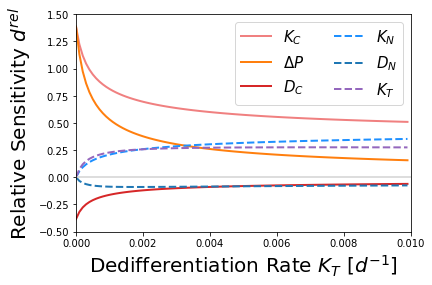

In [7]:
# Calculate parameter sensitivities under
# standard parametrisation for systematically
# altered dedifferentiation rate K_T
f = lambda K_T: calculate_sensitivity_vector([1.0, 1.0, K_T, 0.18, 0.05, 0.05, 7])
K_T = np.arange(0, 0.01, 0.0001)
y = np.array(list(map(f, K_T)))

# Plot parameter sensitivities
plt.plot(K_T, y[:,0], label="$K_C$", c="lightcoral", lw=2)
plt.plot(K_T, y[:,3], label="$\Delta P$", c="C1", lw=2)
plt.plot(K_T, y[:,4], label="$D_C$", c="C3", lw=2)
plt.plot(K_T, y[:,1], label="$K_N$", c="dodgerblue", linestyle="--", lw=2)
plt.plot(K_T, y[:,5], label="$D_N$", c="C0", linestyle="--", lw=2)
plt.plot(K_T, y[:,2], label="$K_T$", c="C4", linestyle="--", lw=2)

# Lines, legend, limits, labels
plt.hlines([0], 0, 0.01, color="lightgrey")
plt.legend(loc=1, fontsize=15, ncol=2)
plt.xlim((0,0.01))
plt.ylim((-.5,1.5))
plt.xlabel("$\mathrm{Dedifferentiation \ Rate \ } K_T \ [d^{-1}]$", fontsize=20)
plt.ylabel("$\mathrm{Relative \ Sensitivity \ } d^{rel}$", fontsize=20)


# Figure 5C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.72it/s]


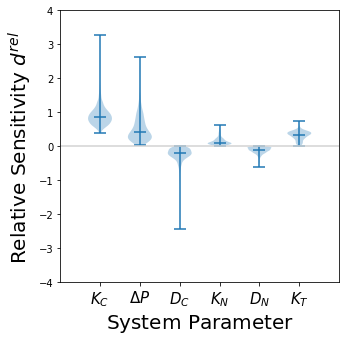

In [8]:
# Simulate a cohort of 1000 patients
# to get relative parameter sensitivities
results = simulate_cohort(n = 1000, random_seed = 0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.violinplot([results.iloc[:,0],
               (results.iloc[:,3]),
               (results.iloc[:,4]),
               (results.iloc[:,1]),
               (results.iloc[:,5]),
               (results.iloc[:,2])],
    showmedians=True, widths=.6, vert=True)


# Aesthetics
plt.ylim((-4, 4))
plt.xlim((0,7))
plt.hlines([0], 0, 7, color="lightgrey")
plt.xlabel("$\mathrm{System \ Parameter}$", fontsize=20)
plt.ylabel(r"$\mathrm{Relative \ Sensitivity \ }d^{rel}$", fontsize=20)
plt.xticks([1,2,3,4,5,6])
ax.set_xticklabels(["$K_C$", "$\Delta P$", "$D_C$", "$K_N$", "$D_N$", "$K_T$"], fontsize=15);